# Baseline Model

In [35]:
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D  # For custom legend markers
import numpy as np
import pandas as pd
import plotly.express as px
import re
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import seaborn as sns
import warnings # ignore warnings
warnings.filterwarnings('ignore')

In [36]:
df = pd.read_csv('../data/customers_100k.csv', sep='|') 

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 21 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   account_id                       100000 non-null  object 
 1   country_name                     100000 non-null  object 
 2   account_category                 100000 non-null  object 
 3   bi_account_classification        100000 non-null  object 
 4   customer_type                    100000 non-null  object 
 5   region                           100000 non-null  object 
 6   sic_code                         100000 non-null  int64  
 7   employee_number                  100000 non-null  int64  
 8   revenue_in_eur                   100000 non-null  float64
 9   number_distinct_active_licenses  100000 non-null  int64  
 10  major_edition                    100000 non-null  object 
 11  total_connections_12m            100000 non-null  int64  
 12  tot

In [38]:
df.head(10)

,account_id,country_name,account_category,bi_account_classification,customer_type,region,sic_code,employee_number,revenue_in_eur,number_distinct_active_licenses,...,total_connections_12m,total_endpoints_12m,total_devices_12m,last_invoice_date_created,current_sales_channel,age_customer,number_renewals,account_value_in_eur,billings_ltm_prorated,business_model
0,ac6a99474410f1c59c91da3f0cf9cf3f,Tonga,Standard,Inside Sales,Customer,APAC,7381,8,1502000.0,1,...,54,4,2,2023-11-23 01:57:47,Webshop,6,5,2532.84,466.47,S
1,1cc66628ed41f3db5a55195e93277a04,Costa Rica,Standard,Inside Sales,Customer,AMERICAS,5049,11,1814000.0,1,...,3385,158,51,2023-10-07 19:35:11,Webshop,1,0,1298.15,972.57,S
2,db5f3cdd5629b9591b720b9b7e077df2,Costa Rica,Standard,Inside Sales,Customer,AMERICAS,7389,16,13444000.0,1,...,12,2,2,2023-12-02 02:03:05,Webshop,2,1,155.83,76.69,S
3,bebb4028688f519f36ed220855b0a62f,Costa Rica,Standard,Reseller,End-User Reseller,AMERICAS,8711,36,7066000.0,3,...,1724,206,30,2023-10-25 23:32:46,Inside Sales,7,5,7550.16,1088.58,S
4,507c0bfb67895d773e3f8bd33b861d09,Costa Rica,Standard,Inside Sales,Customer,AMERICAS,6531,312,61054000.0,2,...,6493,611,31,2023-11-17 04:16:51,Inside Sales,10,1,4688.33,1593.70,S
5,b1267a5b953b7267de811510f838172b,Costa Rica,Standard,Inside Sales,Customer,AMERICAS,5943,25,4881000.0,1,...,583,3,5,2023-08-21 01:11:38,Webshop,5,4,971.96,198.63,S
6,3315ad169d4d2e9080f1377c44377c7c,Costa Rica,Standard,Reseller,Reseller,AMERICAS,7378,15,3013000.0,9,...,2181,311,7,2023-09-28 04:27:43,Reseller,7,15,66581.67,837.31,S
7,8ca7b69eda1a06b32e60fff1c6db3b28,Costa Rica,Standard,Inside Sales,Customer,AMERICAS,1,717,159214000.0,1,...,2415,244,4,2023-12-22 06:27:18,Other,12,6,2986.48,211.88,S
8,5bd2eea4e2320b9246b41a8f54fb02d2,Costa Rica,SMB,Inside Sales,Customer,AMERICAS,8111,5,934000.0,3,...,22037,3766,1311,2023-09-22 01:48:17,Inside Sales,9,4,46022.86,9129.48,S
9,bbfb03bca60fb0185be3f36d12c99b3f,Costa Rica,Standard,Inside Sales,Customer,AMERICAS,8731,22,4308000.0,2,...,4064,672,15,2023-12-20 01:21:26,Inside Sales,15,4,12584.99,1308.89,S


## Data Preprocessing

In [39]:
df.drop(columns=['business_model', 'last_invoice_date_created'], inplace=True)

In [40]:
# Define a dictionary to map SIC code ranges to major industry groups
major_groups = {
    range(1, 10): 'Agriculture, Forestry, and Fishing',
    range(10, 15): 'Mining',
    range(15, 18): 'Construction',
    range(20, 40): 'Manufacturing',
    range(40, 50): 'Transportation, Communications, Electric, Gas, and Sanitary Services',
    range(50, 52): 'Wholesale Trade',
    range(52, 60): 'Retail Trade',
    range(60, 68): 'Finance, Insurance, and Real Estate',
    range(70, 90): 'Services',
    range(90, 100): 'Public Administration'
}

# Map SIC code ranges to major industry group descriptions
def map_to_major_group(sic_code):
    for group_range, description in major_groups.items():
        if sic_code // 100 in group_range:
            return description
    return 'Unknown'

In [41]:
df['industry'] = df['sic_code'].apply(map_to_major_group)
df.drop(columns=['account_id','country_name','sic_code'], inplace=True)

In [42]:
df.head(10)

,account_category,bi_account_classification,customer_type,region,employee_number,revenue_in_eur,number_distinct_active_licenses,major_edition,total_connections_12m,total_endpoints_12m,total_devices_12m,current_sales_channel,age_customer,number_renewals,account_value_in_eur,billings_ltm_prorated,industry
0,Standard,Inside Sales,Customer,APAC,8,1502000.0,1,Business,54,4,2,Webshop,6,5,2532.84,466.47,Services
1,Standard,Inside Sales,Customer,AMERICAS,11,1814000.0,1,Premium,3385,158,51,Webshop,1,0,1298.15,972.57,Wholesale Trade
2,Standard,Inside Sales,Customer,AMERICAS,16,13444000.0,1,Remote Access,12,2,2,Webshop,2,1,155.83,76.69,Services
3,Standard,Reseller,End-User Reseller,AMERICAS,36,7066000.0,3,Corporate,1724,206,30,Inside Sales,7,5,7550.16,1088.58,Services
4,Standard,Inside Sales,Customer,AMERICAS,312,61054000.0,2,Corporate,6493,611,31,Inside Sales,10,1,4688.33,1593.70,"Finance, Insurance, and Real Estate"
5,Standard,Inside Sales,Customer,AMERICAS,25,4881000.0,1,Remote Access,583,3,5,Webshop,5,4,971.96,198.63,Retail Trade
6,Standard,Reseller,Reseller,AMERICAS,15,3013000.0,9,Corporate,2181,311,7,Reseller,7,15,66581.67,837.31,Services
7,Standard,Inside Sales,Customer,AMERICAS,717,159214000.0,1,Business,2415,244,4,Other,12,6,2986.48,211.88,Unknown
8,SMB,Inside Sales,Customer,AMERICAS,5,934000.0,3,Corporate,22037,3766,1311,Inside Sales,9,4,46022.86,9129.48,Services
9,Standard,Inside Sales,Customer,AMERICAS,22,4308000.0,2,Corporate,4064,672,15,Inside Sales,15,4,12584.99,1308.89,Services


In [43]:
# Preprocess the data

# Separate numeric and categorical columns
cat_cols = ['account_category', 'bi_account_classification', 'customer_type', 
            'region', 'major_edition', 'current_sales_channel', 'industry']

num_cols = [col for col in df.columns if col not in cat_cols]

df_cols = num_cols + cat_cols

In [44]:
# Preprocess numeric data
scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Preprocess categorical data
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

In [45]:
df.head(10)

,account_category,bi_account_classification,customer_type,region,employee_number,revenue_in_eur,number_distinct_active_licenses,major_edition,total_connections_12m,total_endpoints_12m,total_devices_12m,current_sales_channel,age_customer,number_renewals,account_value_in_eur,billings_ltm_prorated,industry
0,1.00,0.25,0.000000,0.5,0.000013,0.000003,0.000000,0.0,0.000046,0.000038,0.000076,1.0,0.294118,0.023585,0.001077,0.000670,0.7
1,1.00,0.25,0.000000,0.0,0.000018,0.000004,0.000000,0.6,0.002967,0.002010,0.003819,1.0,0.000000,0.000000,0.000552,0.001398,1.0
2,1.00,0.25,0.000000,0.0,0.000028,0.000030,0.000000,0.8,0.000010,0.000013,0.000076,1.0,0.058824,0.004717,0.000066,0.000109,0.7
3,1.00,1.00,0.333333,0.0,0.000064,0.000016,0.012987,0.2,0.001511,0.002625,0.002215,0.0,0.352941,0.023585,0.003210,0.001565,0.7
4,1.00,0.25,0.000000,0.0,0.000573,0.000139,0.006494,0.2,0.005692,0.007810,0.002291,0.0,0.529412,0.004717,0.001993,0.002292,0.2
5,1.00,0.25,0.000000,0.0,0.000044,0.000011,0.000000,0.8,0.000510,0.000026,0.000306,1.0,0.235294,0.018868,0.000413,0.000284,0.6
6,1.00,1.00,1.000000,0.0,0.000026,0.000007,0.051948,0.2,0.001912,0.003969,0.000458,0.8,0.352941,0.070755,0.028307,0.001204,0.7
7,1.00,0.25,0.000000,0.0,0.001319,0.000361,0.000000,0.0,0.002117,0.003111,0.000229,0.6,0.647059,0.028302,0.001270,0.000304,0.9
8,0.75,0.25,0.000000,0.0,0.000007,0.000002,0.012987,0.2,0.019322,0.048204,0.100053,0.0,0.470588,0.018868,0.019566,0.013138,0.7
9,1.00,0.25,0.000000,0.0,0.000039,0.000010,0.006494,0.2,0.003563,0.008591,0.001069,0.0,0.823529,0.018868,0.005350,0.001882,0.7


In [46]:
# Extract features columns excluding 'account_id'
features_df = df

# Convert DataFrame to numpy array
features = features_df.to_numpy()

## PCA

In [47]:
pca = PCA()
pca.fit(features)
print(pca.explained_variance_ratio_)

[3.84418591e-01 2.10416331e-01 1.45201459e-01 1.12105494e-01
 7.29304471e-02 5.56716457e-02 1.63455096e-02 1.84453626e-03
 3.21866428e-04 2.92299843e-04 1.37230773e-04 8.60430103e-05
 8.14795149e-05 7.63288153e-05 4.07151332e-05 2.52097653e-05
 4.81323654e-06]


Number of components explaining at least 80% variance: 4


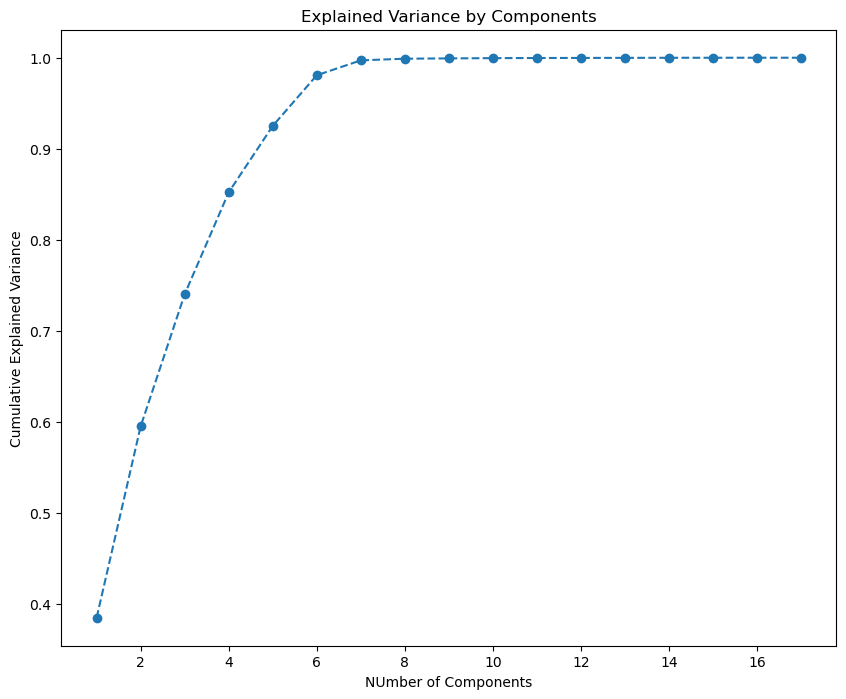

In [48]:
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize= (10, 8))
plt.plot(range(1,18), cumulative_explained_variance, marker = 'o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('NUmber of Components')
plt.ylabel('Cumulative Explained Variance')

# Find the number of components that explain at least 80% of the variance
n_components_80 = np.argmax(cumulative_explained_variance >= 0.80) + 1
print(f"Number of components explaining at least 80% variance: {n_components_80}")

In [49]:
pca = PCA(n_components=4)
features_pca = pca.fit_transform(features)

## Determine the number of clusters(k)

In [50]:
# Define a range of k values to test
k_range = range(1, 20)

wcss = []
for k in k_range:
    print('Now on k {}'.format(k))
    kmeans = KMeans(n_clusters=k, random_state=0).fit(features_pca)
    wcss.append(kmeans.inertia_)

Now on k 1
Now on k 2
Now on k 3
Now on k 4
Now on k 5
Now on k 6
Now on k 7
Now on k 8
Now on k 9
Now on k 10
Now on k 11
Now on k 12
Now on k 13
Now on k 14
Now on k 15
Now on k 16
Now on k 17
Now on k 18
Now on k 19


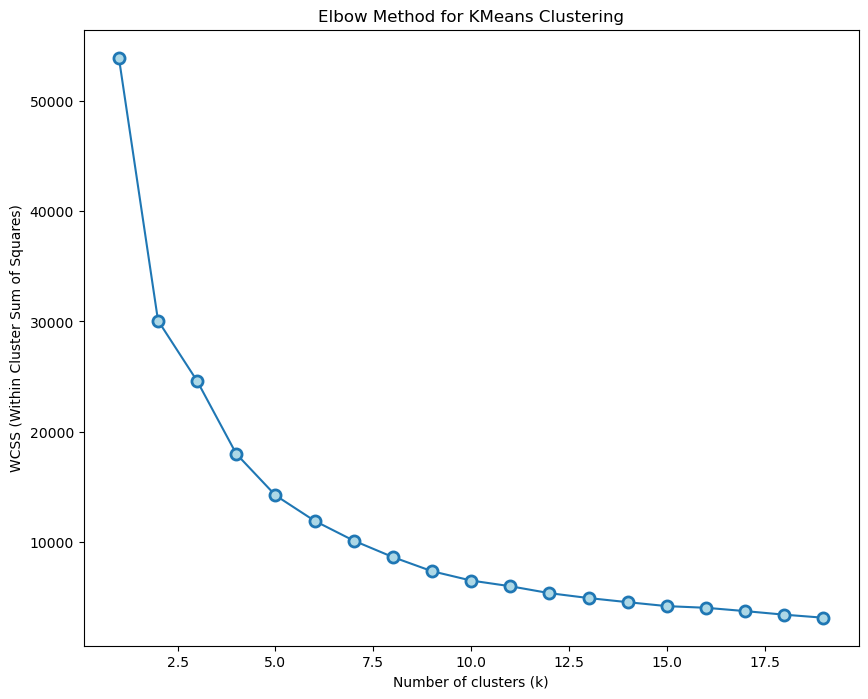

In [51]:
# Plotting WCSS vs k to identify the elbow point
plt.figure(figsize=(10, 8))
plt.plot(k_range, wcss, 'o-', markerfacecolor='lightblue', markeredgewidth=2, markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within Cluster Sum of Squares)')
plt.title('Elbow Method for KMeans Clustering')
plt.show()

## Clustering

In [52]:
# Fit the KMeans model
kmeans = KMeans(n_clusters=4, random_state=0).fit(features_pca)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

df_pca = pd.concat([df.reset_index(drop=True), pd.DataFrame(features_pca)], axis=1)
df_pca.columns.values[-3: ] = ['Component 1', 'Component 2', 'Component 3']
df_pca['clusters'] = kmeans.labels_
df_pca['cluster_kmeans'] = kmeans.predict(features_pca)
df_pca.groupby(['cluster_kmeans']).mean()

,account_category,bi_account_classification,customer_type,region,employee_number,revenue_in_eur,number_distinct_active_licenses,major_edition,total_connections_12m,total_endpoints_12m,...,age_customer,number_renewals,account_value_in_eur,billings_ltm_prorated,industry,0,Component 1,Component 2,Component 3,clusters
cluster_kmeans,,,,,,,,,,,,,,,,,,,,,
0,0.998813,0.309395,0.029399,0.939987,0.000703,0.000499,0.002926,0.698455,0.000585,0.000712,...,0.244789,0.015221,0.001253,0.000930,0.566834,-0.431404,-0.133660,0.445496,-0.018760,0.0
1,0.985604,0.251546,0.004038,0.946155,0.000499,0.000243,0.006276,0.281868,0.002468,0.003774,...,0.399316,0.019305,0.003240,0.002134,0.581541,0.547479,-0.088507,0.014685,0.001491,1.0
2,0.998683,0.333481,0.041624,0.941055,0.000455,0.000194,0.002704,0.044054,0.001005,0.001617,...,0.285732,0.018161,0.001649,0.001070,0.575779,-0.426864,-0.198008,-0.206733,0.009216,2.0
3,0.970058,0.262223,0.010698,0.003960,0.000699,0.000365,0.003002,0.286159,0.001609,0.002021,...,0.248445,0.015864,0.002327,0.001716,0.582356,-0.132525,0.793322,-0.057675,-0.004331,3.0


In [53]:
df_pca.cluster_kmeans.value_counts()

1    39456
2    30944
0    14955
3    14645
Name: cluster_kmeans, dtype: int64

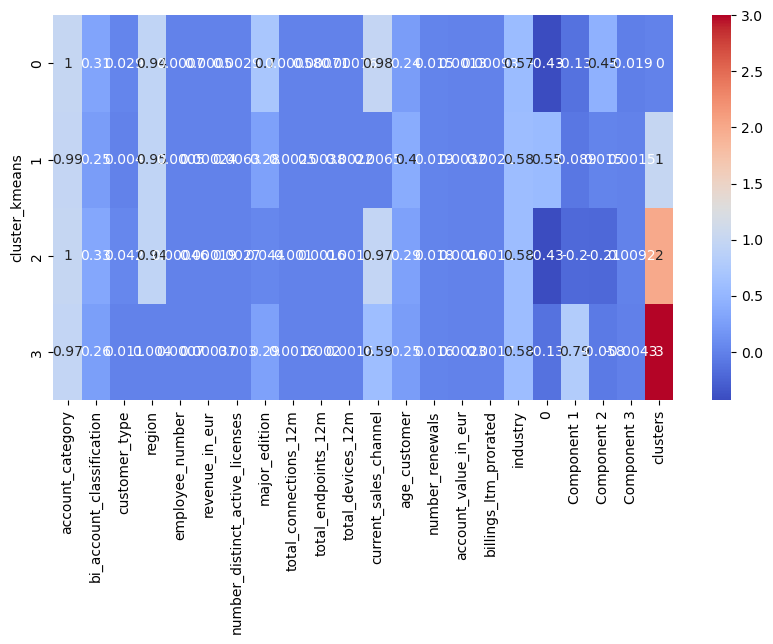

In [54]:
# Visualize the correlation matrix
plt.figure(figsize=(10,5))
sns.heatmap(df_pca.groupby(['cluster_kmeans']).mean(), cmap='coolwarm', annot=True)
plt.show()

In [55]:
clusters=pd.DataFrame(features, columns=features_df.columns)
clusters['label']=kmeans.labels_
polar=clusters.groupby("label").mean().reset_index()
polar=pd.melt(polar,id_vars=["label"])
fig = px.line_polar(polar, r="value", theta="variable", color="label", line_close=True,height=800,width=1400)
fig.show()

Os resultados obtidos são justificados pelas seguintes razões:
- As variveis numericas, devido à sua distribuição centrada num intervalo muito baixo, o que faz com que existem imensos outrliers, demonstram não possuir uma importancia grande para o modelo, que por justa-cause não lida bem com esses mesmos;
- Também a multicolineariedade, tem um papel fulcral nos resultados obtidos, sendo que piora a performance do modelo;
- As escalas atribuidas pelos métodos de scaling e encoding, demonstram não serem eficazes, pelo atribuem maior importancia às variáveis categoricas do que às numericas, devido aos numeros serem de uma escalha diferente e maior.

## Evaluation

In [56]:
# Calculate Silhouette Score
silhouette_avg = silhouette_score(features_df, cluster_labels)
print(f'Silhouette Score: {silhouette_avg:.3f}')

Silhouette Score: 0.364


In [57]:
# Calculate Davies-Bouldin Index
davies_bouldin_avg = davies_bouldin_score(features_df, cluster_labels)
print(f'Davies-Bouldin Index: {davies_bouldin_avg:.3f}')

Davies-Bouldin Index: 1.155
